In [ ]:
!pip install baselines --no-deps

     |████████████████████████████████| 123 kB 4.1 MB/s 
  Created wheel for baselines: filename=baselines-0.1.5-py3-none-any.whl size=163902 sha256=3fc47d873572728862524d26e6dfa8a4480534537fea6a9e3d1d483b8cf0df6b
  Stored in directory: /root/.cache/pip/wheels/64/27/40/3b266f230c825e6b219bfdd5447566d4d109b66fc4e0c074ed
Successfully built baselines


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python -m atari_py.import_roms /content/drive/MyDrive/game_ai/roms

copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from ROMS/Air Raid (Men-A-Vision) (PAL) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying amidar.bin from ROMS/Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/amidar.bin
copying assault.bin from ROMS/Assault (AKA Sky Alien) (1983) (Bomb - Onbase) (CA281).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/assault.bin
copying asterix.bin from ROMS/Asterix (AKA Taz) (07-27-1983) (Atari, Jerome Domurat, Steve Woita) (CX2696) (Prototype).bin to /usr/local/lib/python3.7/dist-packages/a

In [ ]:
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Configuration paramaters for the whole setup
seed = 42
gamma = 0.99    # Discount factor for past rewards
lr = 0.0001     # Learning rate of RMSprop optimizer
epsilon = 1.0   # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 10000

# Use the Baseline Atari environment because of Deepmind helper functions
env = make_atari("BreakoutNoFrameskip-v4")
# Warp the frames, grey scale, stake four frame and scale to smaller ratio
env = wrap_deepmind(env, frame_stack=True, scale=True)
env.seed(seed)

"""
## Implement the Deep Q-Network
This network learns an approximation of the Q-table, which is a mapping between
the states and actions that an agent will take. For every state we'll have four
actions, that can be taken. The environment provides the state, and the action
is chosen by selecting the larger of the four Q-values predicted in the output layer.
"""

num_actions = 4

def create_q_model():
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(84, 84, 4,))

    # Convolutions on the frames on the screen
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)
    layer4 = layers.Flatten()(layer3)
    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)


# The first model makes the predictions for Q-values which are used to
# make a action.
model = create_q_model()
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = create_q_model()

In [ ]:
# RMS prop optimizer with a learning rate of 0.0001
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr, rho=0.99)

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
# Maximum replay length
max_memory_length = 10000
# Train the model after 4 actions
update_after_actions = 4
# How many frames to train the model on
max_frames = 200000
# How often to update the target network
update_target_network = 10000
# Using huber loss for stability
loss_function = keras.losses.Huber()

while frame_count < max_frames:  # Run until the DQN is trained on 2 million frames
    state = np.array(env.reset())
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1

        # Use epsilon-greedy for exploration
        if epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame only when the buffer is full
        if frame_count % update_after_actions == 0 and len(done_history) >= batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + (1 - done_sample) * gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    running_reward = np.mean(episode_reward_history[-100:])

    episode_count += 1

    if running_reward > 40:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

print("Training loop completed !!!")

model_dir = "/content/drive/MyDrive/game_ai/model"
model.save(model_dir)
print("DQN weights saved ;)")

results_dir = "/content/drive/MyDrive/game_ai/results/reward_history"
np.save(results_dir,episode_reward_history)
print("Reward history saved ;)")

running reward: 0.23 at episode 304, frame count 10000
running reward: 0.25 at episode 607, frame count 20000
running reward: 0.18 at episode 923, frame count 30000
running reward: 0.37 at episode 1216, frame count 40000
running reward: 0.39 at episode 1507, frame count 50000
running reward: 0.23 at episode 1807, frame count 60000
running reward: 0.25 at episode 2100, frame count 70000
running reward: 0.29 at episode 2397, frame count 80000
running reward: 0.23 at episode 2698, frame count 90000
running reward: 0.24 at episode 3021, frame count 100000
running reward: 0.23 at episode 3327, frame count 110000
running reward: 0.40 at episode 3615, frame count 120000
running reward: 0.24 at episode 3906, frame count 130000
running reward: 0.30 at episode 4172, frame count 140000
running reward: 0.20 at episode 4479, frame count 150000
running reward: 0.23 at episode 4786, frame count 160000
running reward: 0.21 at episode 5106, frame count 170000
running reward: 0.30 at episode 5407, frame

In [ ]:
model = keras.models.load_model(model_dir,compile=False)

In [ ]:
import gym

seed = 42

# Use the Baseline Atari environment because of Deepmind helper functions
env = make_atari("BreakoutNoFrameskip-v4")
# Warp the frames, grey scale, stake four frame and scale to smaller ratio
env = wrap_deepmind(env, frame_stack=True, scale=True)
env.seed(seed)

video_dir = "/content/drive/MyDrive/game_ai/videos"
env = gym.wrappers.Monitor(env,video_dir,video_callable= lambda episode_id:True, force = True)

In [ ]:
n_episodes = 10
returns = []

for i in range(n_episodes):
  ret = 0
  state = np.array(env.reset())
  done = False
  while(not done):
    # Predict action Q-values
    state_tensor = tf.convert_to_tensor(state)
    state_tensor = tf.expand_dims(state_tensor, 0)
    state_tensor = np.array(state_tensor)
    action_probs = model.predict(state_tensor)
    # Take best action
    action = tf.argmax(action_probs[0]).numpy()
    # Update the environment
    next_state , reward, done, _ = env.step(action)
    state = next_state
    episode_reward += reward
    ret += reward
  returns.append(ret)
env.close()

print("Returns: {}".format(returns))

Returns:[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


# **Q4**

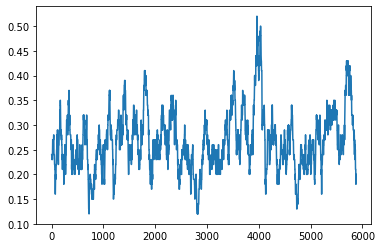

In [ ]:
import matplotlib.pyplot as plt

episode_reward_history = np.load("/content/drive/MyDrive/game_ai/results/reward_history.npy")
mean_rewards = np.convolve(episode_reward_history, np.ones(100)/100, mode="valid")
plt.plot(mean_rewards)